In [55]:
import numpy as np
import pandas as pd 
import os
import cv2

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Input, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from accelerate import Accelerator

In [2]:
devices = tf.config.list_physical_devices('GPU')
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.config.experimental.set_memory_growth(devices[0], True)

In [4]:
accelerator = Accelerator()
device = 'gpu'
device = accelerator.device

In [5]:
data = pd.read_csv('./hmnist_28_28_RGB.csv')
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2


In [6]:
metadata = pd.read_csv('./HAM10000_metadata.csv')
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
locations = list(metadata['localization'].unique())
locations

['scalp',
 'ear',
 'face',
 'back',
 'trunk',
 'chest',
 'upper extremity',
 'abdomen',
 'unknown',
 'lower extremity',
 'genital',
 'neck',
 'hand',
 'foot',
 'acral']

In [8]:
location_map = {value : key for key, value in enumerate(locations)}
location_map

{'scalp': 0,
 'ear': 1,
 'face': 2,
 'back': 3,
 'trunk': 4,
 'chest': 5,
 'upper extremity': 6,
 'abdomen': 7,
 'unknown': 8,
 'lower extremity': 9,
 'genital': 10,
 'neck': 11,
 'hand': 12,
 'foot': 13,
 'acral': 14}

In [9]:
data['age'] = metadata['age']
data['location'] = metadata['localization'].map(location_map)
data['sex'] = metadata['sex'].map({'male' : 1, 'female' : 0})
data.head()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label,age,location,sex
0,192,153,193,195,155,192,197,154,185,202,...,183,147,166,185,154,177,2,80.0,0,1.0
1,25,14,30,68,48,75,123,93,126,158,...,25,14,28,25,14,27,2,80.0,0,1.0
2,192,138,153,200,145,163,201,142,160,206,...,159,124,142,136,104,117,2,80.0,0,1.0
3,38,19,30,95,59,72,143,103,119,171,...,25,12,17,25,12,15,2,80.0,0,1.0
4,158,113,139,194,144,174,215,162,191,225,...,172,135,149,109,78,92,2,75.0,1,1.0


In [32]:
y = data['label']
x_img = data.drop(columns = ['label', 'age', 'sex', 'location'])
x_patient_info = pd.concat([data['age'], data['sex'], data['location']], axis = 1, ignore_index = True)

In [33]:
x_patient_info

,0,1,2
0,80.0,1.0,0
1,80.0,1.0,0
2,80.0,1.0,0
3,80.0,1.0,0
4,75.0,1.0,1
...,...,...,...
10010,40.0,1.0,7
10011,40.0,1.0,7
10012,40.0,1.0,7
10013,80.0,1.0,2


In [11]:
classes = {4: ('nv', ' melanocytic nevi'), 
           6: ('mel', 'melanoma'), 
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'), 
           5: ('vasc', ' pyogenic granulomas and hemorrhage'), 
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),  
           3: ('df', 'dermatofibroma')}

C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Frequency Distribution of Classes')

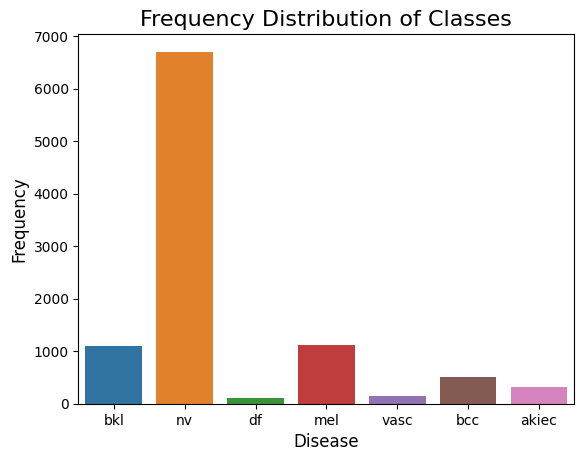

In [12]:
sns.countplot(x = 'dx', data = metadata)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency', size=12)
plt.title('Frequency Distribution of Classes', size=16)

Text(0.5, 1.0, 'Gender of Patient')

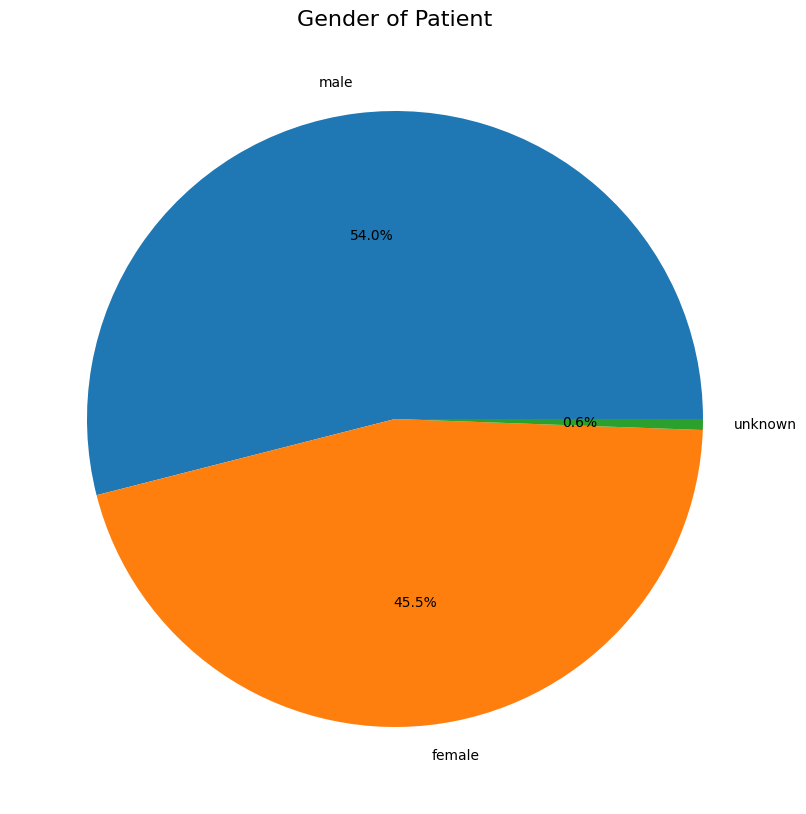

In [13]:
bar, ax = plt.subplots(figsize = (10,10))
plt.pie(metadata['sex'].value_counts(), labels = metadata['sex'].value_counts().index, autopct="%.1f%%")
plt.title('Gender of Patient', size=16)

C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of Age of Patients')

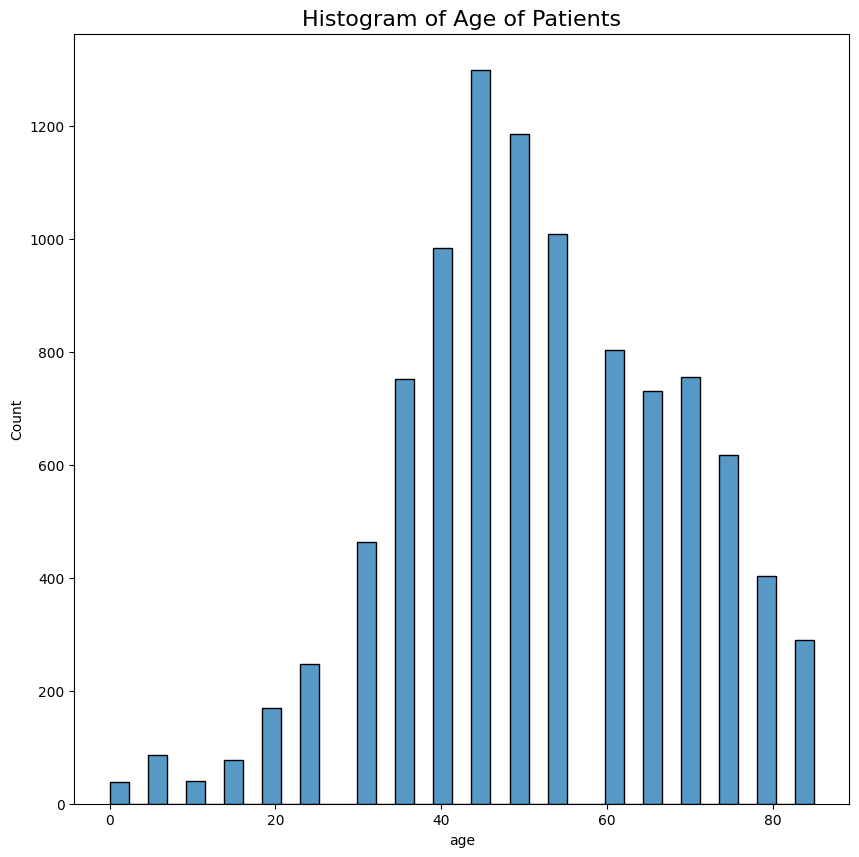

In [14]:
bar, ax = plt.subplots(figsize=(10,10))
sns.histplot(metadata['age'])
plt.title('Histogram of Age of Patients', size=16)

C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Ca

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'back'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'trunk'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'abdomen'),
  Text(5, 0, 'face'),
  Text(6, 0, 'chest'),
  Text(7, 0, 'foot'),
  Text(8, 0, 'scalp'),
  Text(9, 0, 'neck'),
  Text(10, 0, 'unknown'),
  Text(11, 0, 'hand'),
  Text(12, 0, 'genital'),
  Text(13, 0, 'ear'),
  Text(14, 0, 'acral')])

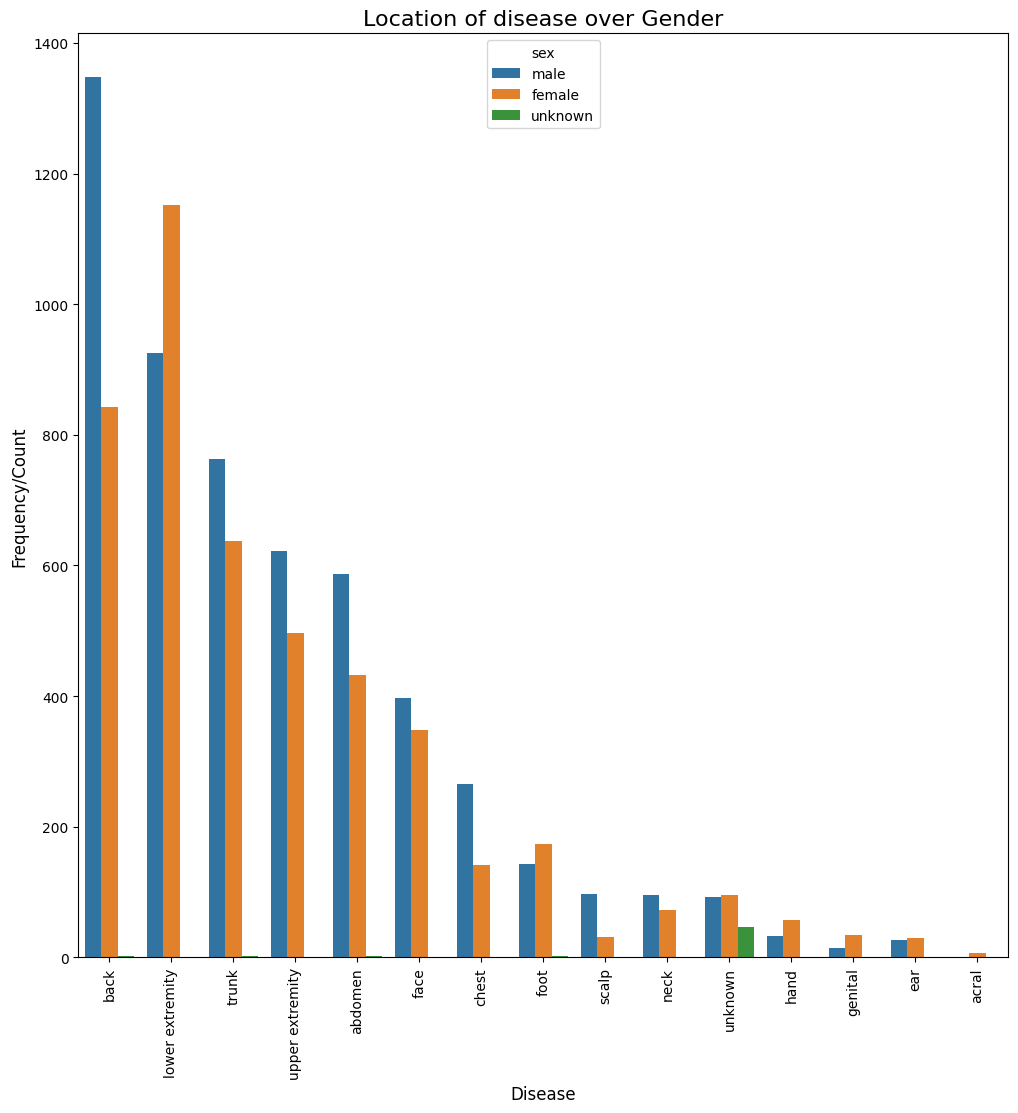

In [15]:
value = metadata[['localization', 'sex']].value_counts().to_frame()
value.reset_index(level=[1,0 ], inplace=True)
temp = value.rename(columns = {'localization':'location', 0: 'count'})

bar, ax = plt.subplots(figsize = (12, 12))
sns.barplot(x = 'location',  y='count', hue = 'sex', data = temp)
plt.title('Location of disease over Gender', size = 16)
plt.xlabel('Disease', size=12)
plt.ylabel('Frequency/Count', size=12)
plt.xticks(rotation = 90)

In [16]:
oversample = RandomOverSampler()
x_img,y  = oversample.fit_resample(x_img,y)

In [17]:
x_img = np.array(x_img).reshape(-1,28,28,3)
print('Shape of X :',x_img.shape)

Shape of X : (46935, 28, 28, 3)


In [18]:
x_img = (x_img-np.mean(x_img))/np.std(x_img)
X_img_train, X_img_test, Y_img_train, Y_img_test = train_test_split(x_img,y, test_size=0.2, random_state=1)

In [19]:
X_img_train.shape

(37548, 28, 28, 3)

In [58]:
model = Sequential()
model.add(Conv2D(16, kernel_size = (3,3), input_shape = (28, 28, 3), activation = 'relu', padding = 'same'))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same'))
model.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
model.add(Conv2D(128, kernel_size = (3,3), activation = 'relu'))
model.add(Conv2D(512, kernel_size = (3,3), activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), padding = 'same'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 16)        448       
                                                                 
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 13, 13, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 9, 9, 128)         73856     
                                                      

In [59]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_img_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

In [60]:
model.compile(loss = SparseCategoricalCrossentropy(),
             optimizer = Adam(),
              metrics = ['accuracy'])

In [61]:
history = model.fit(X_img_train,
                    Y_img_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 50,
                    callbacks=[callback])

Epoch 1/50
232/235 [============================>.] - ETA: 0s - loss: 1.3322 - accuracy: 0.4718
Epoch 1: saving model to best_img_model.h5
235/235 [==============================] - 3s 12ms/step - loss: 1.3280 - accuracy: 0.4735 - val_loss: 0.9505 - val_accuracy: 0.6322
Epoch 2/50
234/235 [============================>.] - ETA: 0s - loss: 0.7173 - accuracy: 0.7275
Epoch 2: saving model to best_img_model.h5
235/235 [==============================] - 3s 12ms/step - loss: 0.7167 - accuracy: 0.7278 - val_loss: 0.5716 - val_accuracy: 0.7872
Epoch 3/50
232/235 [============================>.] - ETA: 0s - loss: 0.4538 - accuracy: 0.8288
Epoch 3: saving model to best_img_model.h5
235/235 [==============================] - 3s 12ms/step - loss: 0.4522 - accuracy: 0.8293 - val_loss: 0.3658 - val_accuracy: 0.8566
Epoch 4/50
234/235 [============================>.] - ETA: 0s - loss: 0.3160 - accuracy: 0.8803
Epoch 4: saving model to best_img_model.h5
235/235 [==============================] - 3s 11

C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\adity\miniconda3\envs\tfgpu\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf va

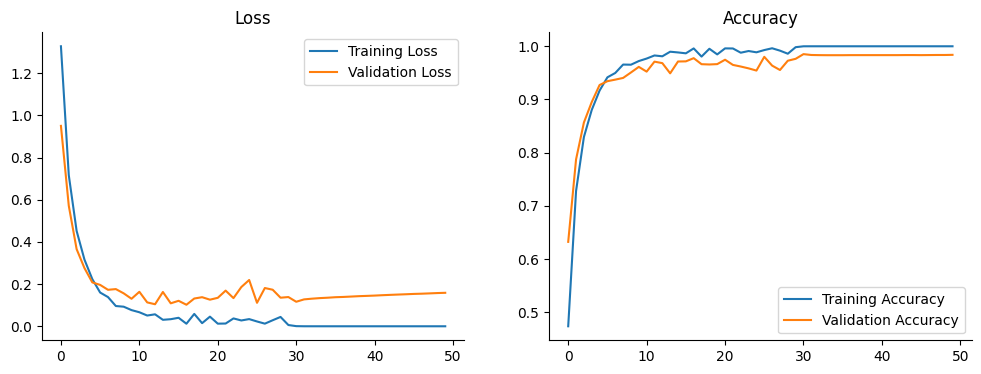

In [62]:
fig, axes = plt.subplots(1, 2, figsize = (12, 4))

sns.lineplot(x = range(len(history.history["loss"])), y = history.history["loss"], ax = axes[0], label = "Training Loss")
sns.lineplot(x = range(len(history.history["loss"])), y = history.history["val_loss"], ax = axes[0], label = "Validation Loss")

sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["accuracy"], ax = axes[1], label = "Training Accuracy")
sns.lineplot(x = range(len(history.history["accuracy"])), y = history.history["val_accuracy"], ax = axes[1], label = "Validation Accuracy")
axes[0].set_title("Loss"); axes[1].set_title("Accuracy")

sns.despine()
plt.show()

In [63]:
loss, acc = model.evaluate(X_img_test, Y_img_test, verbose=2)

294/294 - 1s - loss: 0.1308 - accuracy: 0.9824 - 658ms/epoch - 2ms/step


In [49]:
train_x_info, test_x_info, train_y_info, test_y_info = train_test_split(x_patient_info, y, test_size = 0.2, random_state = 1)

In [50]:
info_model = Sequential()
info_model.add(Dense(64, activation = 'relu'))
info_model.add(Dense(32, activation = 'relu'))
info_model.add(Dense(32, activation = 'relu'))
info_model.add(Dense(7, activation = 'softmax'))

In [51]:
info_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_info_model.h5',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)

In [56]:
info_model.compile(loss = MeanAbsolutePercentageError(),
             optimizer = Adam(),
              metrics = ['accuracy'])

In [57]:
history = info_model.fit(train_x_info,
                    train_y_info,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 20,
                    callbacks=[info_callback])

Epoch 1/20
47/51 [==========================>...] - ETA: 0s - loss: nan - accuracy: 0.0319
Epoch 1: saving model to best_info_model.h5
51/51 [==============================] - 1s 8ms/step - loss: nan - accuracy: 0.0326 - val_loss: nan - val_accuracy: 0.0337
Epoch 2/20
41/51 [=======================>......] - ETA: 0s - loss: nan - accuracy: 0.0307
Epoch 2: saving model to best_info_model.h5
51/51 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0331 - val_loss: nan - val_accuracy: 0.0337
Epoch 3/20
44/51 [========================>.....] - ETA: 0s - loss: nan - accuracy: 0.0332
Epoch 3: saving model to best_info_model.h5
51/51 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0331 - val_loss: nan - val_accuracy: 0.0337
Epoch 4/20
50/51 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.0331
Epoch 4: saving model to best_info_model.h5
51/51 [==============================] - 0s 5ms/step - loss: nan - accuracy: 0.0331 - val_l